# Introduction

Problem statement: Predict if an aircraft engine will fail within a particular cycle, given its history of cycles and sensory data. <br>

**CONTENTS**
1. Importing Libraries <br>
2. Load the Dataset <br>
3. Data Preprocessing <br>
    3.1. Generating the classification target variable <br>
    3.2. Normalizing the data set <br>
4. Exploratory Data Analysis - EDA <br>
5. Generating Input Sequence <br>
6. Utility Functions <br>
7. Model Building with SimpleRNN <br>
    7.1 Simple RNN [1 Feature] <br>
    7.2 Simple RNN [25 Features] <br>
    7.3 Bi-Directional RNN [25 Features] <br>
    7.4 LSTM [25 Features] <br>
    7.5 Model Building with GRU [25 Features] <br>

# 1. Importing Libraries

In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU

# 2. Load the Dataset 

In [2]:
# Training data where the last cycle is the failure point for the engines
train_df = pd.read_csv('/PM_train.txt', sep=" ", header=None)

# Test data where the failure point is not given for the engines
test_df = pd.read_csv('/PM_test.txt', sep=" ", header=None)

# We wil print some rows of the train data
train_df.head(100)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,NaN,NaN
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,NaN,NaN
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,NaN,NaN
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,NaN,NaN


In [3]:
# Dropping column 26 and column 27 as it has NaN values only
train_df.dropna(axis=1, inplace=True)
test_df.dropna(axis=1, inplace=True)

In [4]:
# Size of training and testing dataset
print(len(train_df))
print(len(test_df))

20631
13096


In [5]:
# Adding names to the columns
cols_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df.columns = cols_names
test_df.columns = cols_names

train_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236


In [6]:
test_df.head(2)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916


In [7]:
# Load the ground truth for the test data, which indicates the remaining useful cycles for the engines

truth_df = pd.read_csv('/PM_truth.txt', sep=" ", header=None)
truth_df.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [8]:
# Dropping the NAN column
truth_df.dropna(axis=1, inplace=True)
truth_df.head()

,0
0,112
1,98
2,69
3,82
4,91


# 3. Data Preprocessing
We will do the following while preprocessing the training dataset:

1. Generating the classification target variable
2. Normalizing the data set

## 3.1 Generating Classification Target Variable
We will classify the cycles close to breakdown with their respective ids as 1 in the target variable failure_within_w1.

Here, w1 signifies the window_1, which in this case is 30.

**IMP: In this case, during the last cycle the aircraft was in a bad state, and before the last cycle the aircraft indeed required maintenance. here predicting the x number of cycles before the aircraft brake down is very important. 
the number of cycles before the actual breakdown we are referring to it as the window. In this case, the window can be 15, 30, 45 ..etc. it depends upon how early we want to flag the maintenance and the dependency on the accuracy.
In this case we are assuming window size as 30 (Aim to find if the maintenance required before 30 cycles) <br>**

Sort the data set by id and cycles so each engine can have its values sorted and stored in one place. 

In [9]:
train_df.sort_values(['id','cycle'], inplace=True)
test_df.sort_values(['id','cycle'], inplace=True)

First, we find the maximum cycles observed for each engine using groupby() and then merge these values for respective engine data using merge().

Then, we calculate the remaining useful life (RUL) by subtracting the current cycle value from the max. For example, a cycle has a total life of 192 cycles, and it has already run 50 cycles; hence, its RUL will be 192-50 = 142.

In [10]:
# Extract the maximum number of cycles for each engine id.
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()

# Name the columns and merge them with the training data.
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

# Now subtract the current cycle from the max (maximum number of cycles) to calculate the remaining useful life.
train_df['RUL'] = train_df['max'] - train_df['cycle']

#The RUL is calculated for each id.
train_df[['id','cycle','max','RUL']].head()

,id,cycle,max,RUL
0,1,1,192,191
1,1,2,192,190
2,1,3,192,189
3,1,4,192,188
4,1,5,192,187


In [11]:
# We do not need "max" anymore.
train_df.drop('max', axis=1, inplace=True)

Generate label column for training data

In [12]:
# We will make a label that indicates whether an engine is going to fail within w1 cycles.
w1 = 30
train_df['failure_within_w1'] = np.where(train_df['RUL'] <= w1, 1, 0 )

## 3.2 Normalize Training Dataset

In [13]:
# Make a separate feature for the normalized value of the cycle column.
train_df['cycle_norm'] = train_df['cycle']

# Using the difference function, we exclude these columns from the normalization process.
cols_normalize = train_df.columns.difference(['id','cycle','RUL','failure_within_w1'])

# MinMax normalization (from 0 to 1) of sensor data
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

#Join the normalized and non-normalized data.
join_df = train_df[['id','cycle','RUL','failure_within_w1']].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,failure_within_w1,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0.01108


Normalize the test data in the same manner that you normalized the training data.

In [14]:
# We will perform MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']

# MinMax normalization (from 0 to 1) of the sensor data only
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)

#Join the normalized and non-normalized data (it does not have 'RUL' and 'failure_within_w1')
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

Label the test set like we did for the training data.

In [15]:
# Let's calculate the total RUL by summing up the maximum cycles given in the test set and the 
# ground truth additional RUL.
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['additional_rul']

# The respective id can be obtained by adding 1 to the index, as the index starts from 0.
truth_df['id'] = truth_df.index + 1

# Add the max cycles given in the test set and the additional RUL given in the ground truth DataFrame.
truth_df['max'] = rul['max'] + truth_df['additional_rul']
truth_df.drop('additional_rul', axis=1, inplace=True)

# Generate the RUL for the test data.
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# Generate the label columns w0 and w1 for the test data.
test_df['failure_within_w1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,failure_within_w1
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0


# 4. Exploratory Data Analysis - EDA


<AxesSubplot:>

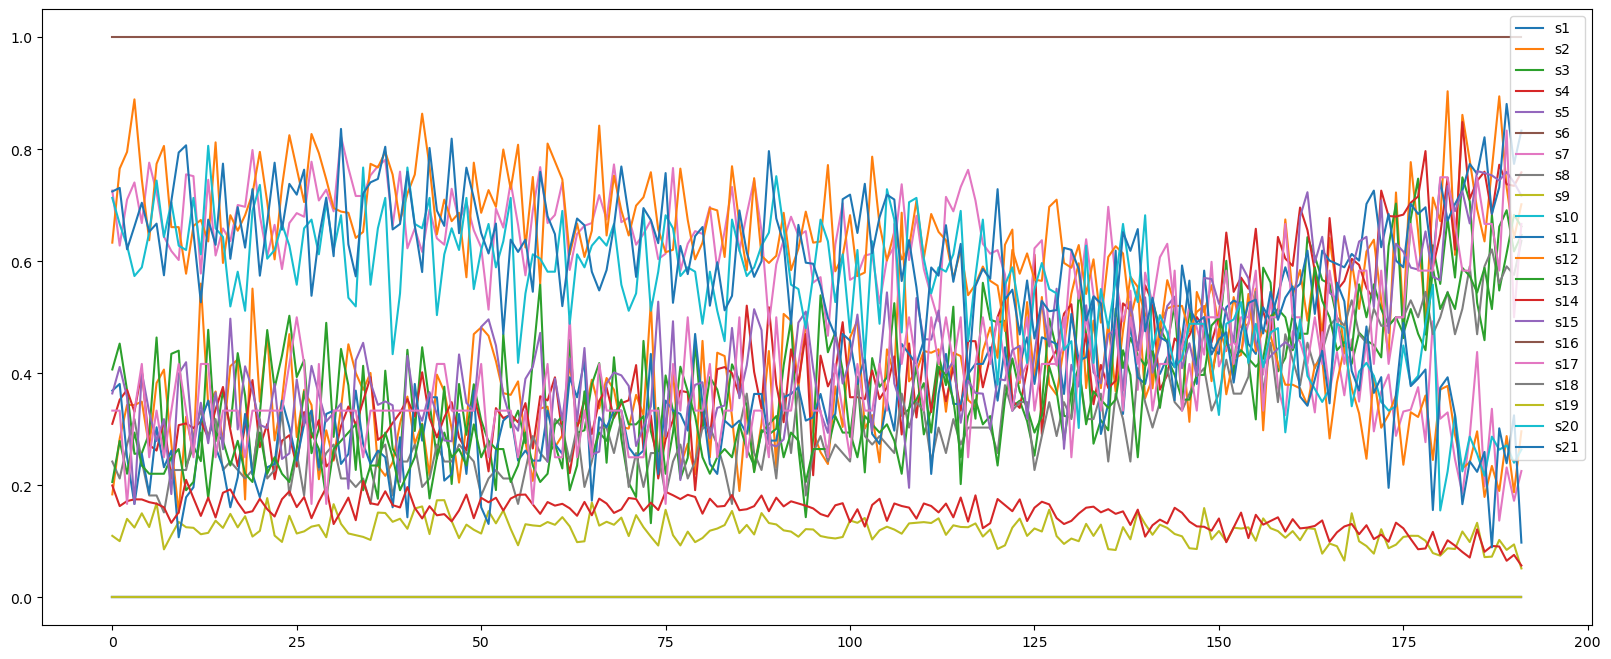

In [16]:
sensor_cols = cols_names[5:]
train_df[train_df.id==1][sensor_cols].plot(figsize=(20, 8))

<AxesSubplot:>

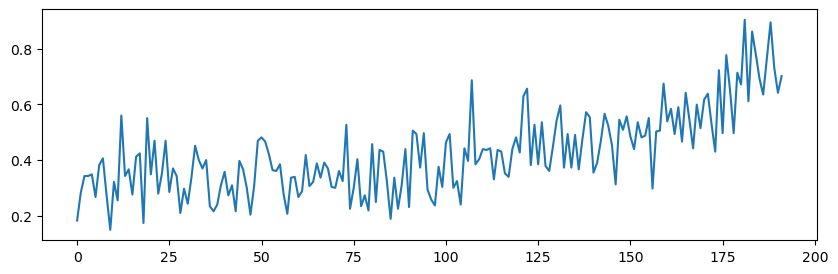

In [17]:
train_df[train_df.id==1][sensor_cols[1]].plot(figsize=(10, 3))

* Sensor 1 values increase when the cycle of number incrceases.
* Sensor 6 values decrease when the cycle of number increases.
* Most other sensors exhibit either an increasing or decreasing trend.


<AxesSubplot:>

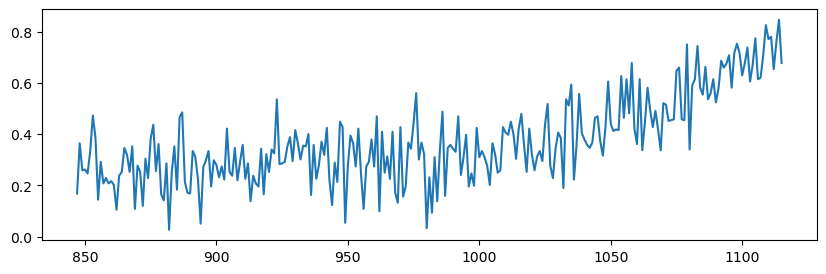

In [18]:
train_df[train_df.id==5][sensor_cols[1]].plot(figsize=(10, 3))

<AxesSubplot:>

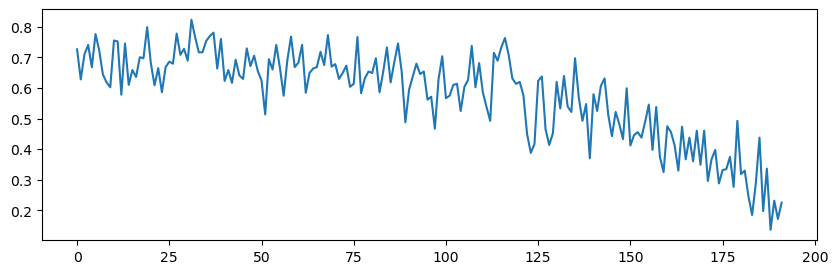

In [19]:
train_df[train_df.id==1][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor1 observations for id 1 and id 5.

Both observations have an upward trend with increasing cycles.

<AxesSubplot:>

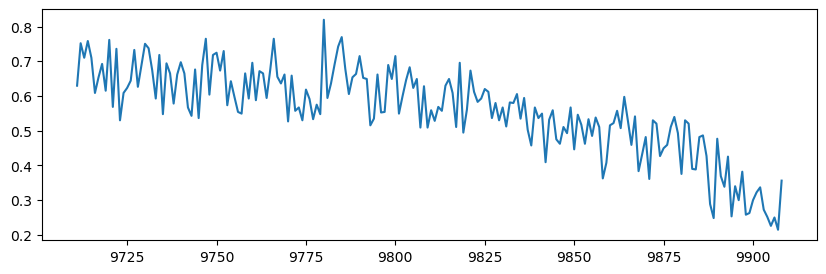

In [20]:
train_df[train_df.id==50][sensor_cols[6]].plot(figsize=(10, 3))

We have plotted sensor6 observations for id 1 and id 50.

Both observations have a downward trend with increasing cycles.

We can see that when the sensor values approach a particular value, the aircraft may fail to work soon.

# 5. Generating Input Sequence


In [21]:
# The sequence length to be used for predictions is as follows:
sequence_length = 50

In [22]:
# The function to generate sequences (samples, time steps, features) for a particular engine id is as follows:

def sequence_generator(feature_df, seq_length, seq_cols):
    # We will not be using any sequence below seq_length.
    # Convert the DataFrame into a NumPy 2D array.
    feature_array = feature_df[seq_cols].values
    num_elements = feature_array.shape[0]

    # We want to generate sequences of 50 timesteps at a time.
    # Hence, we will iterate over two sets of indices: (0,142),(50,192).
    # For example, id1 has 192 rows, and its sequence_length is equal to 50.
    # 0 50 -> From row 0 to row 50
    # 1 51 -> From row 1 to row 51
    # 2 52 -> From row 2 to row 52
    # ...
    # 141 191 -> From row 111 to 191
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield feature_array[start:stop, :]

In [23]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, ["s2"])) # We take only one feature (s2).
           for id in train_df['id'].unique())

# Concatenate the sequences of different engine ids into one array and convert that into a NumPy array 
# [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
#print(list(seq_gen))
seq_set = np.concatenate(list(seq_gen)).astype(np.float32)

# Let’s print the shape of the seq_set  (number of samples, number of time steps, number of features)
seq_set.shape

(15631, 50, 1)

In [24]:
# The function to generate labels is as follows:
def label_generator(label_df, seq_length, label):
    # Funtion will return
    # This function will return the following:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    # Convert the labels into a NumPy 2D array. 

    label_array = label_df[label].values
    num_elements = label_array.shape[0]
        # Remove the first label, as the first prediction will be the (seq_length+1)th label. 
    return label_array[seq_length:num_elements, :]

In [25]:
# Generate labels [[142,1], [121, 1], [3]] --> [1, 2, 3] (ntotal, 1).
label_gen = [label_generator(train_df[train_df['id']==id], sequence_length, ['failure_within_w1']) 
             for id in train_df['id'].unique()]
label_set = np.concatenate(label_gen).astype(np.float32)
label_set.shape

(15631, 1)

# 6. Utility Functions

In [26]:
# The function for plotting the change in the model’s accuracy on the train and validation sets is as follows:
def plot_model_accuracy(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['accuracy'])
  plt.plot(model_name_history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [27]:
# We will define a function to plot the change in the loss on the train and validation sets.
def plot_training_curve(model_name_history, width = 10, height = 10):
  fig_acc = plt.figure(figsize=(width, height))
  plt.plot(model_name_history.history['loss'])
  plt.plot(model_name_history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [28]:
def analyze_model_on_train_set(input_sequence_set, model_name):

    # The training metrics are as follows:
    model_history_scores = model_name.evaluate(input_sequence_set, label_set, verbose=1, batch_size=50)
    print('Train Accurracy: {}'.format(model_history_scores[1]))

    # Make predictions and compute the confusion matrix.
    y_pred = (model_name.predict(input_sequence_set, verbose=1, batch_size=200) > 0.5).astype("int32")
    y_true = label_set

    test_set = pd.DataFrame(y_pred)
    test_set.to_csv('binary_submit_train.csv', index = None)

    # Calculate the confusion matrix
    model_cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Set font scale for better readability
    sns.heatmap(model_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute the precision and recall.
    model_precision = precision_score(y_true, y_pred)
    model_recall = recall_score(y_true, y_pred)
    print( 'Train Precision = ', model_precision, '\n', 'Train Recall = ', model_recall)

In [29]:
def analyze_model_on_test_set(input_sequence_columns, model_path, width= 10, height=5):
    # We will consider all the last sequences of the test set.
    last_test_seq = [test_df[test_df['id']==id][input_sequence_columns].values[-sequence_length:] 
                        for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]
    last_test_seq = np.asarray(last_test_seq).astype(np.float32)

    # Get the labels of the test set.
    y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
    last_test_label = test_df.groupby('id')['failure_within_w1'].nth(-1)[y_mask].values
    last_test_label = last_test_label.reshape(last_test_label.shape[0],1).astype(np.float32)

    # If the best model weights were saved, load them.
    if os.path.isfile(model_path):
        print("using " + model_path)
        model_estimator = load_model(model_path)

    # Test the metrics.
    start = time.time()
    scores_test = model_estimator.evaluate(last_test_seq, last_test_label, verbose=2)
    end = time.time()
    print("Total time taken for inferencing: ", "{:.2f}".format((end-start)), " secs")

    print('Test Accurracy: {}'.format(scores_test[1]))

    # Make predictions and compute the confusion matrix.
    y_model_estimator_pred_test = (model_estimator.predict(last_test_seq) >0.5).astype("int32")
    y_true_test = last_test_label

    test_set = pd.DataFrame(y_model_estimator_pred_test)
    test_set.to_csv('binary_submit_test.csv', index = None)

    # Calculate the confusion matrix
    model_cm = confusion_matrix(y_true_test, y_model_estimator_pred_test)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Set font scale for better readability
    sns.heatmap(model_cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute the precision and recall values.
    model_estimator_precision_test = precision_score(y_true_test, y_model_estimator_pred_test)
    model_estimator_recall_test = recall_score(y_true_test, y_model_estimator_pred_test)
    f1_test = 2 * (model_estimator_precision_test * model_estimator_recall_test) / (model_estimator_precision_test + model_estimator_recall_test)
    print( 'Test Precision: ', model_estimator_precision_test, '\n', 'Test Recall: ', model_estimator_recall_test,'\n', 'Test F1-score:', f1_test )

    # Plot the predicted data in blue and the
    # actual data in green to visually verify the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_model_estimator_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('Prediction')
    plt.ylabel('Value')
    plt.xlabel('Row')
    plt.legend(['Predicted', 'Actual Data'], loc='upper left')
    plt.show()

**SIMPLE RNN WITH 1 FEATURE** <br>
This model utilizes a basic Recurrent Neural Network (RNN) architecture with only one feature as input. <br>
It's suitable for tasks where the input data is sequential and can be represented with a single feature. <br>

Pros: <br>
* Simple architecture, easy to understand and implement. <br>
* Faster training compared to more complex models. <br>

Cons: <br>
* Limited capacity to capture complex patterns in data. <br>
* Prone to vanishing gradient problem in longer sequences. <br>

**SIMPLE RNN WITH 25 FEATURES** <br>
Similar to RNN With 1 Feature, but with 25 features as input. <br>
Suitable for tasks where the input data is more complex and involves multiple features. <br>

Pros: <br>
* Can capture richer information from input data compared to RNN_1_Feature. <br>
* Still relatively simple compared to more advanced architectures. <br>

Cons: <br>
* May suffer from computational inefficiency with higher-dimensional input data. <br>
* Still limited in capturing long-term dependencies in sequences. <br>

**BiDirectional RNN** <br>
This model incorporates information from both past and future time steps by processing the input sequence in both forward and backward directions. <br>
It's effective in capturing dependencies from both preceding and succeeding contexts. <br>

Pros: <br>
* Captures more context information than traditional RNNs. <br>
* Mitigates the vanishing gradient problem to some extent. <br>

Cons: <br>
* Increased computational complexity compared to unidirectional RNNs. <br>
* May require more data for effective training. <br>

**LSTM (Long Short-Term Memory)** <br>
LSTM is a type of RNN architecture designed to overcome the vanishing gradient problem and capture long-term dependencies more effectively. <br>
It incorporates memory cells and gating mechanisms to selectively remember or forget information over time. <br>

Pros: <br>
* Excellent at capturing long-range dependencies in sequential data. <br>
* Less prone to vanishing gradient problem compared to traditional RNNs. <br>

Cons: <br>
* More complex architecture, requiring longer training times. <br>
* More difficult to interpret and tune due to its complexity. <br>

**GRU (Gated Recurrent Unit)** <br>
Similar to LSTM, GRU is another variant of RNN designed to address the limitations of traditional RNNs. <br>
It combines the gating mechanism of LSTM but with a simpler architecture. <br>

Pros: <br>
* Captures long-term dependencies like LSTM but with fewer parameters. <br>
* Generally faster to train compared to LSTM due to its simpler structure. <br>

Cons: <br>
* May not perform as well as LSTM on tasks requiring precise long-term memory retention. <br>
* Still more complex than basic RNN architectures. <br>

# 7. RNN Models

## 7.1 Simple RNN [1 Feature]

In [30]:
out_dim = label_set.shape[1] # 1 label/output for one sequence.
features_dim = seq_set.shape[2] # Number of features (1)


print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd = Sequential()
RNN_fwd.add(SimpleRNN(input_shape=(sequence_length, features_dim), units=1, return_sequences=False))
RNN_fwd.add(Dropout(0.2))
RNN_fwd.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd.summary())

# Define the path to save the model.
RNN_fwd_path = '/Simple_RNN_1_Feature.h5'

Features dimension:  1
Output dimension:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
import time
epochs = 300
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_history = RNN_fwd.fit(seq_set, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/300
75/75 - 4s - loss: 0.6619 - accuracy: 0.7098 - val_loss: 0.6419 - val_accuracy: 0.7660 - 4s/epoch - 59ms/step
Epoch 2/300
75/75 - 2s - loss: 0.6261 - accuracy: 0.7957 - val_loss: 0.6100 - val_accuracy: 0.7992 - 2s/epoch - 23ms/step
Epoch 3/300
75/75 - 2s - loss: 0.5991 - accuracy: 0.8016 - val_loss: 0.5848 - val_accuracy: 0.8018 - 2s/epoch - 24ms/step
Epoch 4/300
75/75 - 2s - loss: 0.5772 - accuracy: 0.8017 - val_loss: 0.5651 - val_accuracy: 0.8018 - 2s/epoch - 23ms/step
Epoch 5/300
75/75 - 2s - loss: 0.5601 - accuracy: 0.8017 - val_loss: 0.5505 - val_accuracy: 0.8018 - 2s/epoch - 23ms/step
Epoch 6/300
75/75 - 2s - loss: 0.5500 - accuracy: 0.8017 - val_loss: 0.5402 - val_accuracy: 0.8018 - 2s/epoch - 23ms/step
Epoch 7/300
75/75 - 2s - loss: 0.5420 - accuracy: 0.8017 - val_loss: 0.5326 - val_accuracy: 0.8018 - 2s/epoch - 24ms/step
Epoch 8/300
75/75 - 2s - loss: 0.5365 - accuracy: 0.8017 - val_loss: 0.5272 - val_accuracy: 0.8018 - 2s/epoch - 24ms/step
Epoch 9/300
75/75 - 2s -

**Model Evaluation on the Train and Validation Sets**

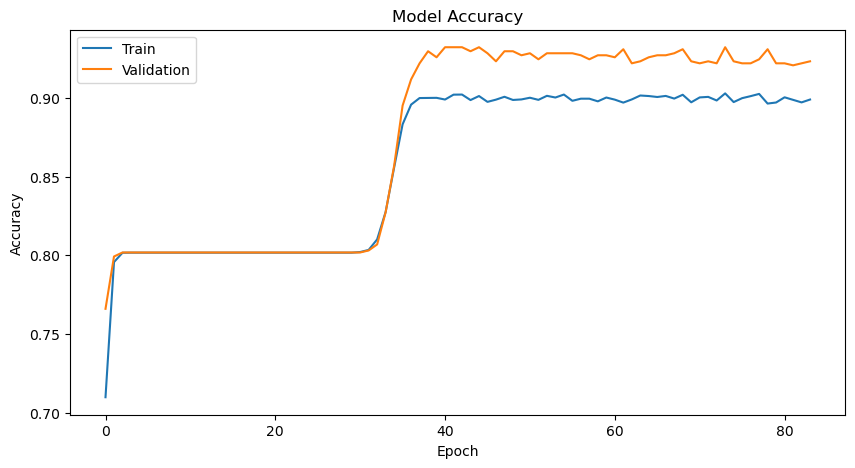

In [32]:
#Call the function.
plot_model_accuracy(RNN_fwd_history,10,5)

**Training Curve**

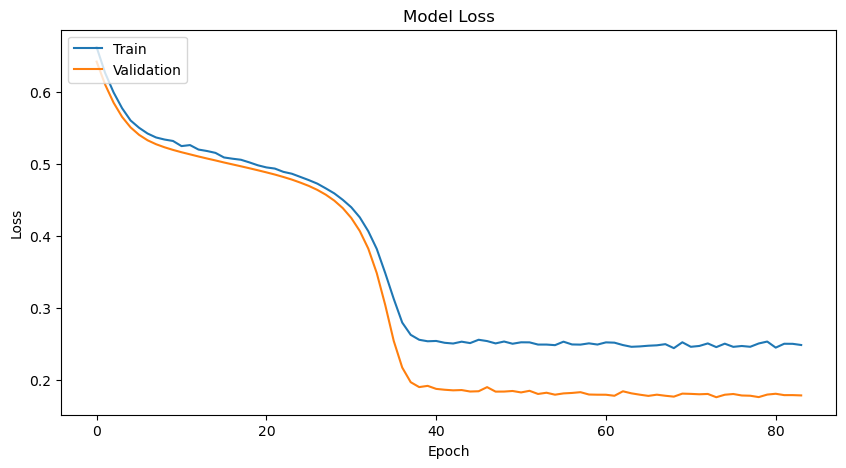

In [33]:
#Call the function.
plot_training_curve(RNN_fwd_history,10,5)

**Model Evaluation on the Train Set**

313/313 [==============================] - 2s 5ms/step - loss: 0.1920 - accuracy: 0.9264
Train Accurracy: 0.9264282584190369
79/79 [==============================] - 1s 5ms/step


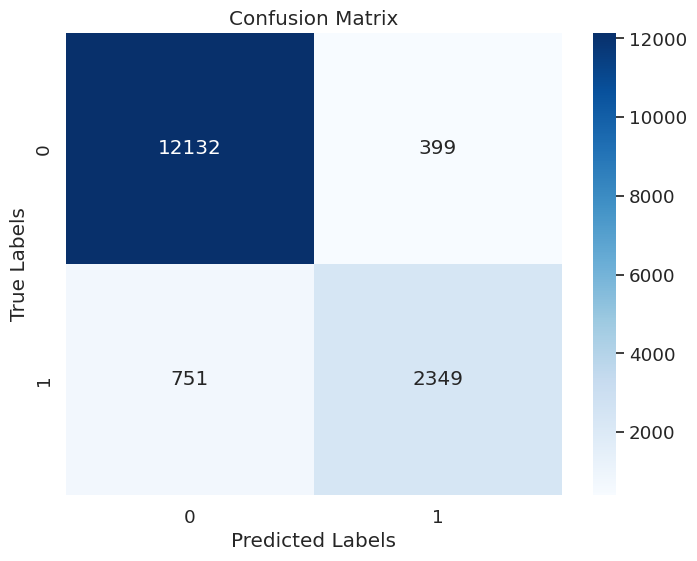

Train Precision =  0.8548034934497817 
 Train Recall =  0.7577419354838709


In [34]:
# Call the function.
analyze_model_on_train_set(seq_set, RNN_fwd)

**Model evaluation on test set**

using /kaggle/working/Simple_RNN_1_Feature.h5
3/3 - 0s - loss: 0.2698 - accuracy: 0.9032 - 199ms/epoch - 66ms/step
Total time taken for inferencing:  0.23  secs
Test Accurracy: 0.9032257795333862
3/3 [==============================] - 0s 5ms/step


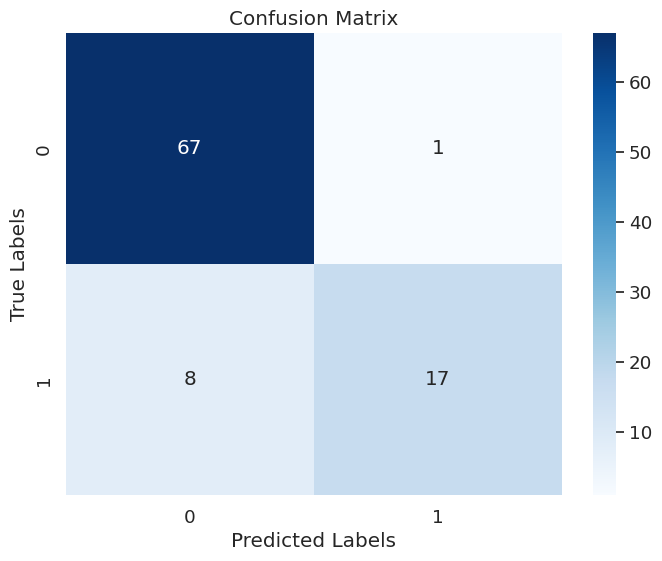

Test Precision:  0.9444444444444444 
 Test Recall:  0.68 
 Test F1-score: 0.7906976744186047


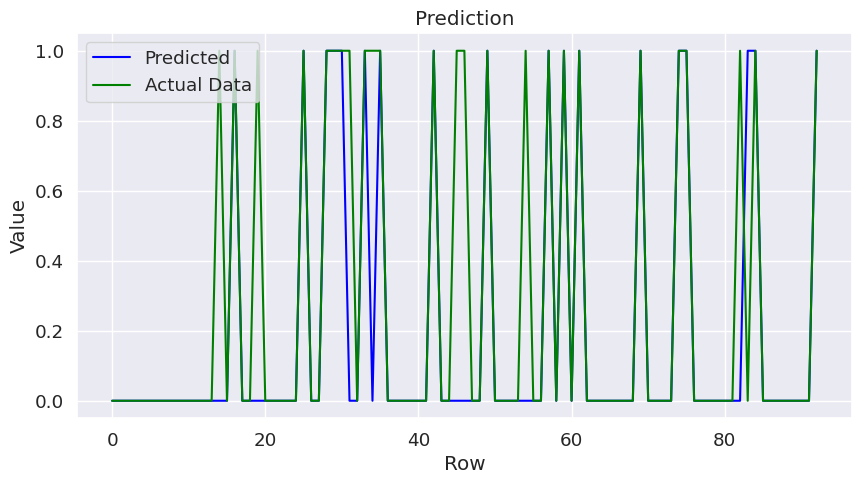

In [35]:
#Call the function.
analyze_model_on_test_set(["s2"], RNN_fwd_path, 10, 5)

## 7.2 Simple RNN With 25 Features

In [36]:
# Pick the feature columns. 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols_25 = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols_25.extend(sensor_cols) # Add the elements of sensor_cols into sequence_cols.

In [37]:
# Generate sequences for each engine id.
# unique() returns all the unique ids in a list.

seq_gen = (list(sequence_generator(train_df[train_df['id']==id], sequence_length, sequence_cols_25)) #We will take all the features (25).
           for id in train_df['id'].unique())

# Concatenate the sequences of the different engine ids into one and convert it into a NumPy array [(142, 50, 25), ...] --> [(ntotal, 50, 25)].
seq_set_f25 = np.concatenate(list(seq_gen)).astype(np.float32)

#The shape denotes (number of samples, number of time steps, number of features).
seq_set_f25.shape

(15631, 50, 25)

In [38]:
features_dim = seq_set_f25.shape[2] # number of features (25).
out_dim = label_set.shape[1] # One label (failure_within_w1).

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_fwd_2 = Sequential()

# Understanding return_sequences and the connection across RNN layers:
# We have to return the sequences from the first layer so the next layer can get the sequence.

RNN_fwd_2.add(SimpleRNN(
         input_shape=(sequence_length, features_dim),
         units=5,
         return_sequences=True))
RNN_fwd_2.add(Dropout(0.2))
RNN_fwd_2.add(SimpleRNN(
          units=3,
          return_sequences=False))
RNN_fwd_2.add(Dropout(0.2))
RNN_fwd_2.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_fwd_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_fwd_2.summary())

# Define the path to save the model.
RNN_fwd_2_path = '/Simple_RNN_25_Features.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 50, 5)             155       
                                                                 
 dropout_1 (Dropout)         (None, 50, 5)             0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 3)                 27        
                                                                 
 dropout_2 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 186
Trainable params: 186
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network.
RNN_fwd_2_history = RNN_fwd_2.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_fwd_2_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 7s - loss: 0.6217 - accuracy: 0.6954 - val_loss: 0.5133 - val_accuracy: 0.8005 - 7s/epoch - 88ms/step
Epoch 2/200
75/75 - 5s - loss: 0.5486 - accuracy: 0.7681 - val_loss: 0.5006 - val_accuracy: 0.8018 - 5s/epoch - 65ms/step
Epoch 3/200
75/75 - 5s - loss: 0.5301 - accuracy: 0.7796 - val_loss: 0.4858 - val_accuracy: 0.8018 - 5s/epoch - 65ms/step
Epoch 4/200
75/75 - 5s - loss: 0.5013 - accuracy: 0.7911 - val_loss: 0.4460 - val_accuracy: 0.8018 - 5s/epoch - 65ms/step
Epoch 5/200
75/75 - 5s - loss: 0.3740 - accuracy: 0.8687 - val_loss: 0.2525 - val_accuracy: 0.9182 - 5s/epoch - 67ms/step
Epoch 6/200
75/75 - 5s - loss: 0.2494 - accuracy: 0.9248 - val_loss: 0.2087 - val_accuracy: 0.9258 - 5s/epoch - 65ms/step
Epoch 7/200
75/75 - 5s - loss: 0.2140 - accuracy: 0.9328 - val_loss: 0.1947 - val_accuracy: 0.9271 - 5s/epoch - 65ms/step
Epoch 8/200
75/75 - 5s - loss: 0.2041 - accuracy: 0.9325 - val_loss: 0.1918 - val_accuracy: 0.9284 - 5s/epoch - 64ms/step
Epoch 9/200
75/75 - 5s -

**Model Evaluation on the Train and Validation Sets**

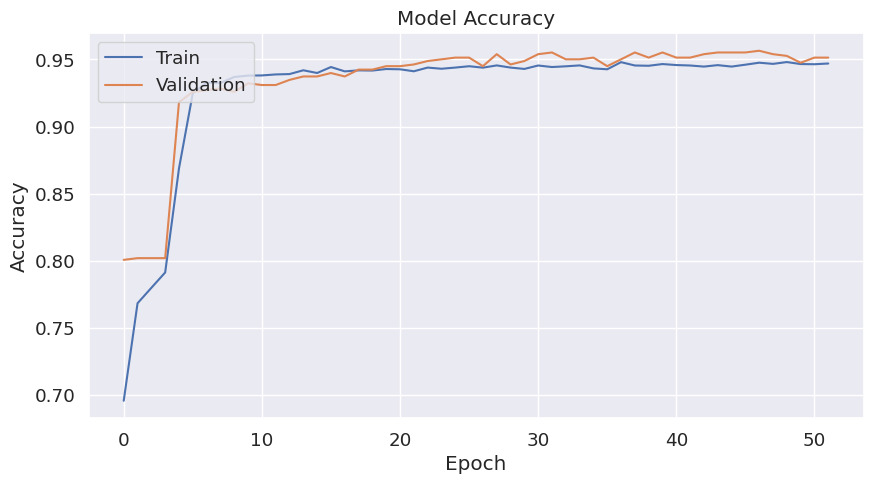

In [40]:
plot_model_accuracy(RNN_fwd_2_history, 10, 5)

**Training Curve**

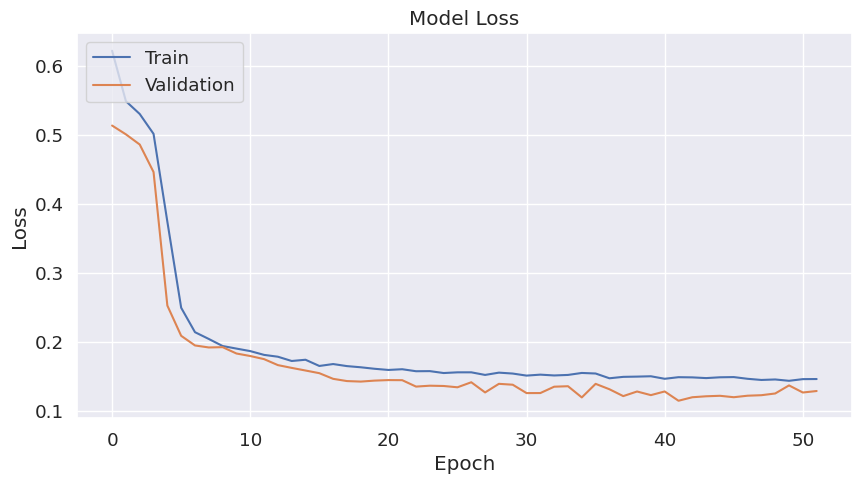

In [41]:
plot_training_curve(RNN_fwd_2_history,10,5)

**Model Evaluation on the Train Set**

313/313 [==============================] - 3s 8ms/step - loss: 0.1257 - accuracy: 0.9511
Train Accurracy: 0.9510588049888611
79/79 [==============================] - 1s 8ms/step


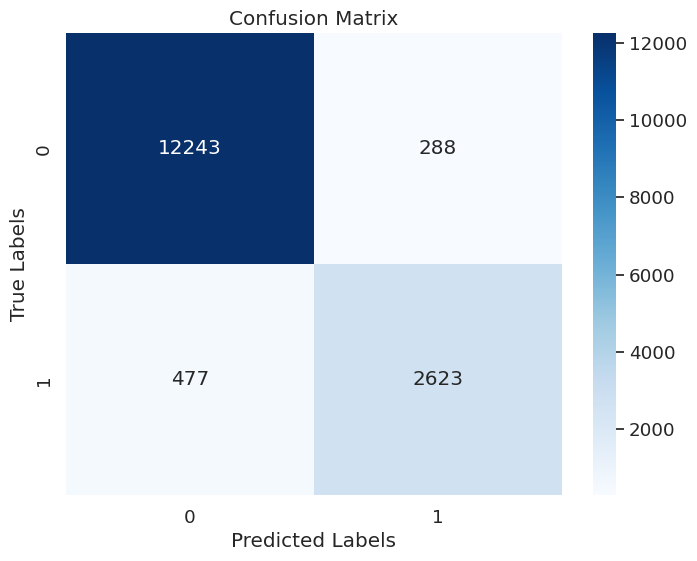

Train Precision =  0.9010649261422191 
 Train Recall =  0.8461290322580645


In [42]:
analyze_model_on_train_set(seq_set_f25, RNN_fwd_2)

**Model Evaluation on Test Set**

using /kaggle/working/Simple_RNN_25_Features.h5
3/3 - 0s - loss: 0.2132 - accuracy: 0.9140 - 296ms/epoch - 99ms/step
Total time taken for inferencing:  0.33  secs
Test Accurracy: 0.9139785170555115
3/3 [==============================] - 0s 8ms/step


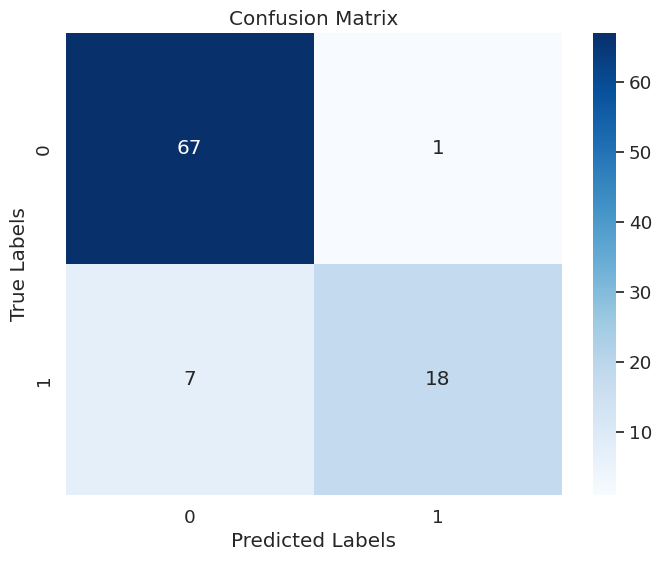

Test Precision:  0.9473684210526315 
 Test Recall:  0.72 
 Test F1-score: 0.8181818181818181


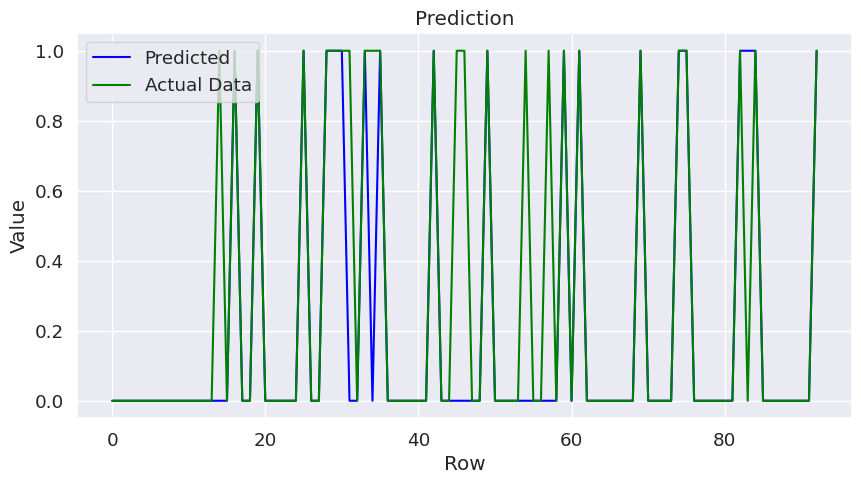

In [43]:
analyze_model_on_test_set(sequence_cols_25, RNN_fwd_2_path, 10, 5)

## 7.3 Bidirectional RNN


In [45]:
#Import a bidirectional library.
from tensorflow.keras.layers import Bidirectional

features_dim = seq_set_f25.shape[2] # Number of features (25)
out_dim = label_set.shape[1] # One output for each sequence (failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_bi = Sequential()
RNN_bi.add(Bidirectional(SimpleRNN(input_shape=(sequence_length, features_dim), units=6, return_sequences=True)))
RNN_bi.add(Dropout(0.2))
RNN_bi.add(SimpleRNN(units=3,return_sequences=False))
RNN_bi.add(Dropout(0.2))
RNN_bi.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model.
RNN_bi.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the path to save the model.
RNN_bi_path = '/RNN_BiDirectional.h5'

Features dimension:  25
Output dimension:  1


In [46]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_bi_history = RNN_bi.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_bi_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/200
75/75 - 10s - loss: 0.5050 - accuracy: 0.8003 - val_loss: 0.3840 - val_accuracy: 0.8274 - 10s/epoch - 127ms/step
Epoch 2/200
75/75 - 7s - loss: 0.3476 - accuracy: 0.8927 - val_loss: 0.2852 - val_accuracy: 0.9258 - 7s/epoch - 93ms/step
Epoch 3/200
75/75 - 7s - loss: 0.2879 - accuracy: 0.9145 - val_loss: 0.2579 - val_accuracy: 0.9297 - 7s/epoch - 91ms/step
Epoch 4/200
75/75 - 7s - loss: 0.2605 - accuracy: 0.9210 - val_loss: 0.2334 - val_accuracy: 0.9399 - 7s/epoch - 90ms/step
Epoch 5/200
75/75 - 7s - loss: 0.2393 - accuracy: 0.9251 - val_loss: 0.2187 - val_accuracy: 0.9348 - 7s/epoch - 91ms/step
Epoch 6/200
75/75 - 7s - loss: 0.2184 - accuracy: 0.9325 - val_loss: 0.2015 - val_accuracy: 0.9361 - 7s/epoch - 92ms/step
Epoch 7/200
75/75 - 7s - loss: 0.2055 - accuracy: 0.9403 - val_loss: 0.1899 - val_accuracy: 0.9399 - 7s/epoch - 93ms/step
Epoch 8/200
75/75 - 7s - loss: 0.1941 - accuracy: 0.9424 - val_loss: 0.1842 - val_accuracy: 0.9373 - 7s/epoch - 91ms/step
Epoch 9/200
75/75 - 7

In [47]:
#Print the summary of the model.
print(RNN_bi.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 50, 12)           384       
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 50, 12)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 3)                 48        
                                                                 
 dropout_6 (Dropout)         (None, 3)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 436
Trainable params: 436
Non-trainable params: 0
________________________________________________________

**Model Evaluation on the Train and Validation Sets**

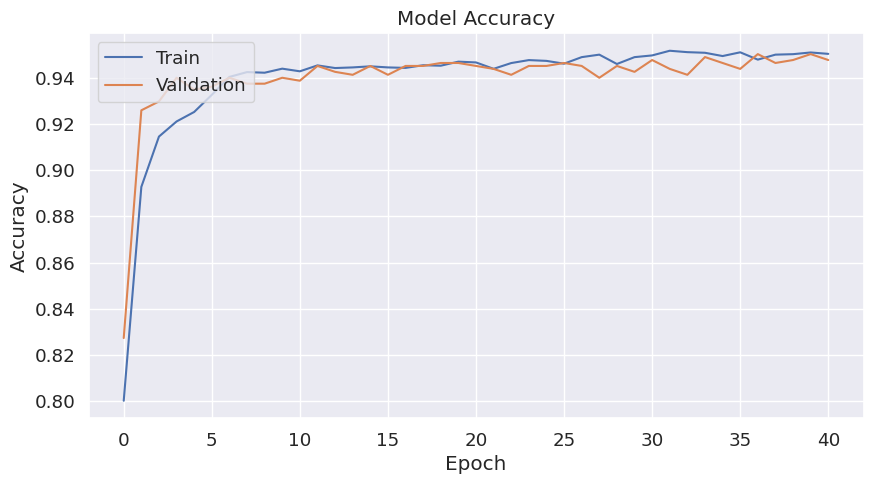

In [48]:
plot_model_accuracy(RNN_bi_history,10,5)

**Training Curve**

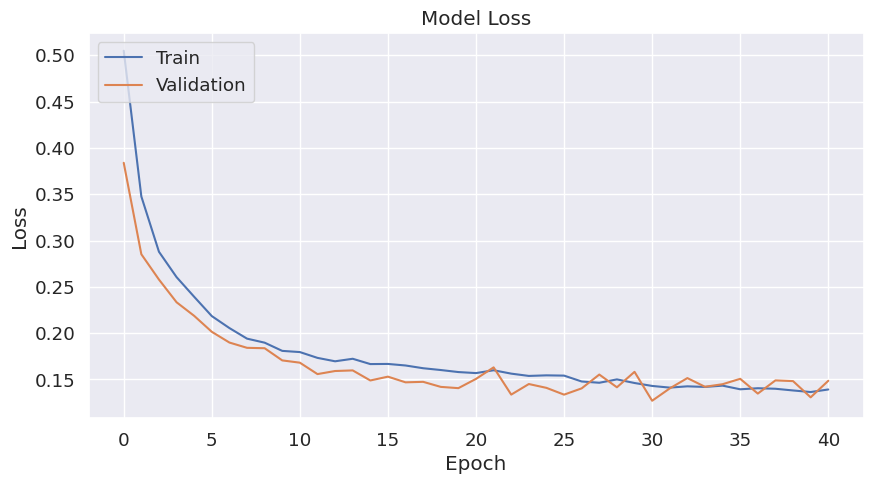

In [49]:
plot_training_curve(RNN_bi_history,10,5)

**Model Evaluation on the Train Set**

313/313 [==============================] - 4s 12ms/step - loss: 0.1176 - accuracy: 0.9552
Train Accurracy: 0.955153226852417
79/79 [==============================] - 1s 11ms/step


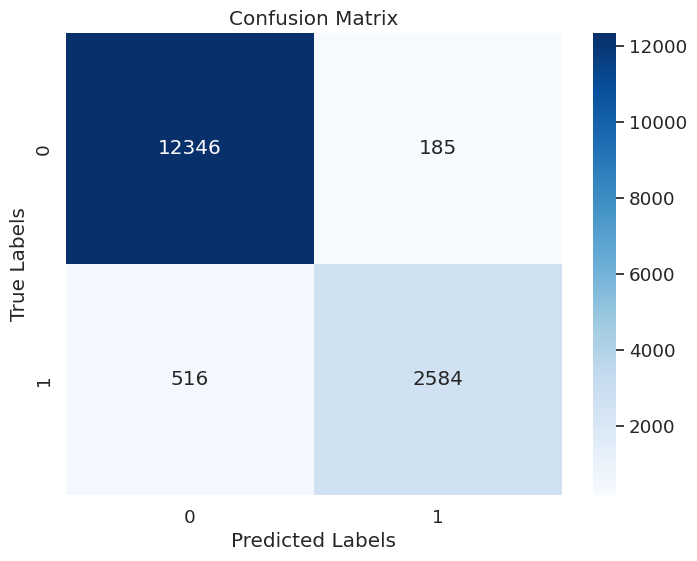

Train Precision =  0.9331888768508487 
 Train Recall =  0.8335483870967741


In [50]:
analyze_model_on_train_set(seq_set_f25, RNN_bi)

**Model Evaluation on the Test Set**

using /kaggle/working/RNN_BiDirectional.h5
3/3 - 0s - loss: 0.1949 - accuracy: 0.9140 - 394ms/epoch - 131ms/step
Total time taken for inferencing:  0.42  secs
Test Accurracy: 0.9139785170555115
3/3 [==============================] - 0s 11ms/step


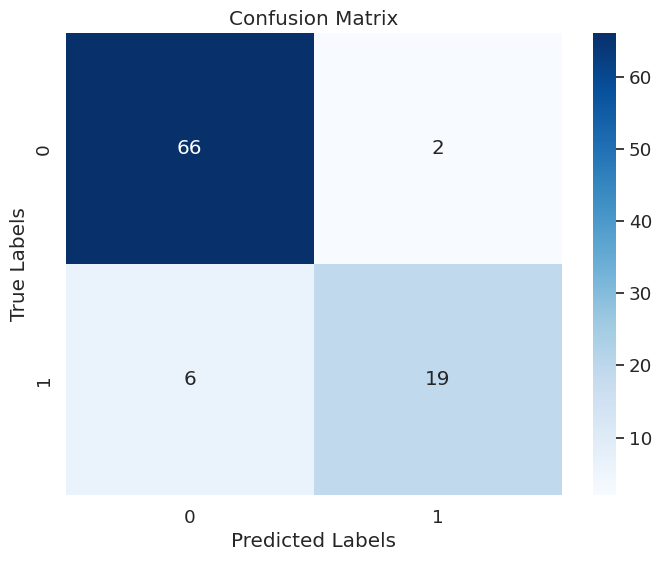

Test Precision:  0.9047619047619048 
 Test Recall:  0.76 
 Test F1-score: 0.8260869565217391


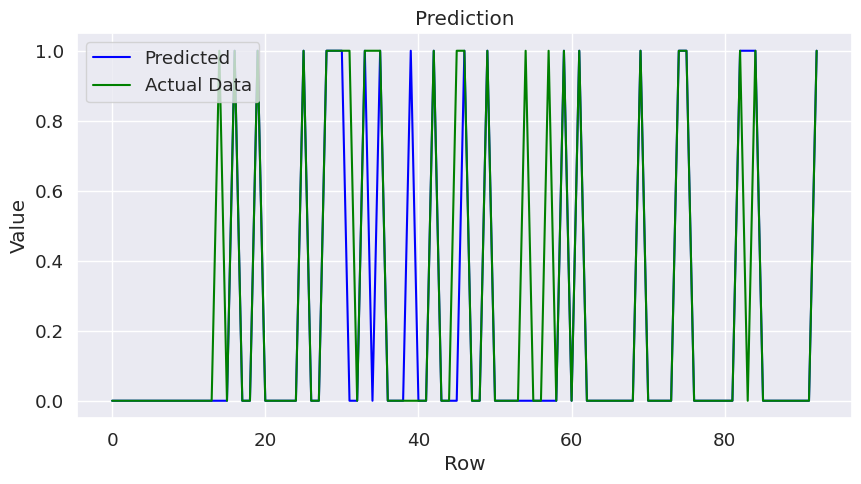

In [51]:
analyze_model_on_test_set(sequence_cols_25, RNN_bi_path,10,5)

## 7.4 LSTM

In [52]:
# Model - (100 LSTM units with 0.2 dropout) + 
#         (50 LSTM units with 0.2 dropout) + 
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_LSTM = Sequential()
RNN_LSTM.add(LSTM(input_shape=(sequence_length, features_dim), units=100, return_sequences=True))
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(LSTM(units=50, return_sequences=False))
RNN_LSTM.add(Dropout(0.2))
RNN_LSTM.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
RNN_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_LSTM.summary())

# Define path to save model
RNN_LSTM_path = '/LSTM.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout_7 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_8 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 80,651
Trainable params: 80,651
Non-trainable params: 0
_________________________________________________________________
None


In [55]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_LSTM_history = RNN_LSTM.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_LSTM_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")


Epoch 1/200
75/75 - 6s - loss: 0.2571 - accuracy: 0.8816 - val_loss: 0.1285 - val_accuracy: 0.9412 - 6s/epoch - 79ms/step
Epoch 2/200
75/75 - 1s - loss: 0.1078 - accuracy: 0.9546 - val_loss: 0.0604 - val_accuracy: 0.9731 - 746ms/epoch - 10ms/step
Epoch 3/200
75/75 - 1s - loss: 0.0911 - accuracy: 0.9614 - val_loss: 0.0454 - val_accuracy: 0.9949 - 735ms/epoch - 10ms/step
Epoch 4/200
75/75 - 1s - loss: 0.0771 - accuracy: 0.9679 - val_loss: 0.0301 - val_accuracy: 0.9949 - 741ms/epoch - 10ms/step
Epoch 5/200
75/75 - 1s - loss: 0.0625 - accuracy: 0.9742 - val_loss: 0.0618 - val_accuracy: 0.9706 - 716ms/epoch - 10ms/step
Epoch 6/200
75/75 - 1s - loss: 0.0684 - accuracy: 0.9702 - val_loss: 0.0928 - val_accuracy: 0.9591 - 715ms/epoch - 10ms/step
Epoch 7/200
75/75 - 1s - loss: 0.0606 - accuracy: 0.9746 - val_loss: 0.0372 - val_accuracy: 0.9847 - 710ms/epoch - 9ms/step
Epoch 8/200
75/75 - 1s - loss: 0.0591 - accuracy: 0.9743 - val_loss: 0.0323 - val_accuracy: 0.9847 - 712ms/epoch - 9ms/step
Epoch

**Model Evaluation on the Train and Validation Sets**

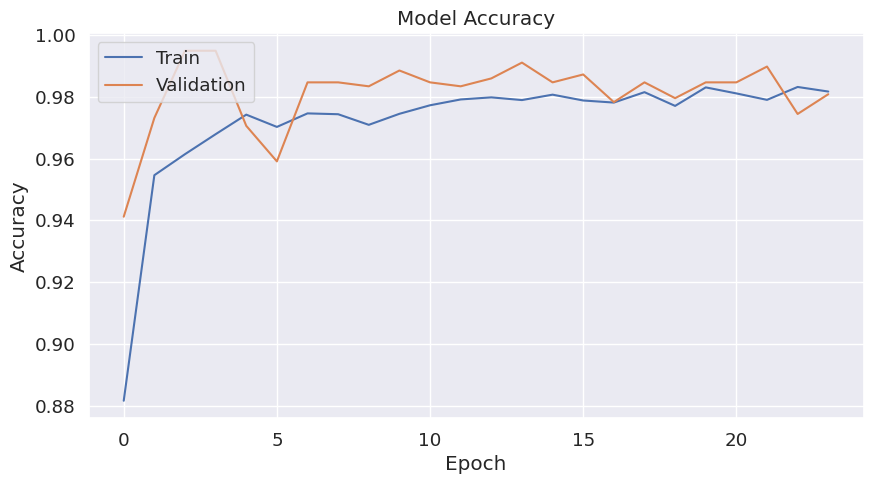

In [56]:
plot_model_accuracy(RNN_LSTM_history,10,5)

**Training Curve**

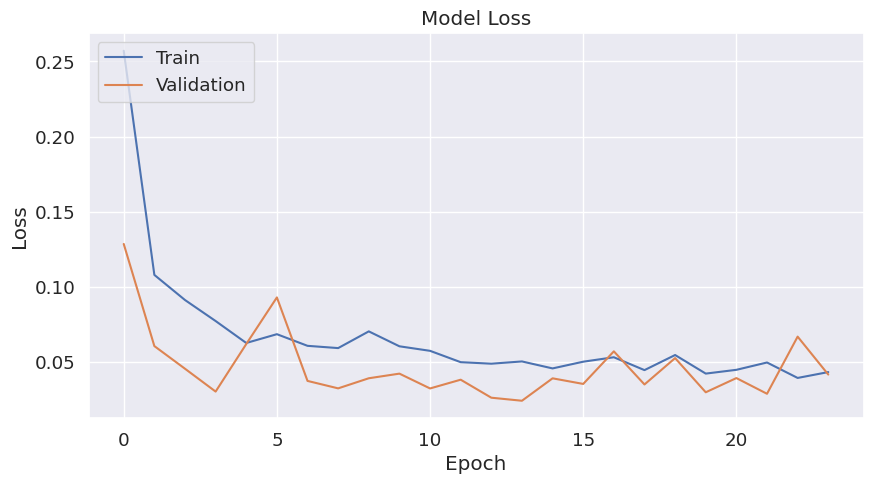

In [57]:
plot_training_curve(RNN_LSTM_history,10,5)

**Model Evaluation on the Train Set**

313/313 [==============================] - 1s 4ms/step - loss: 0.0340 - accuracy: 0.9857
Train Accurracy: 0.9857334494590759
79/79 [==============================] - 1s 4ms/step


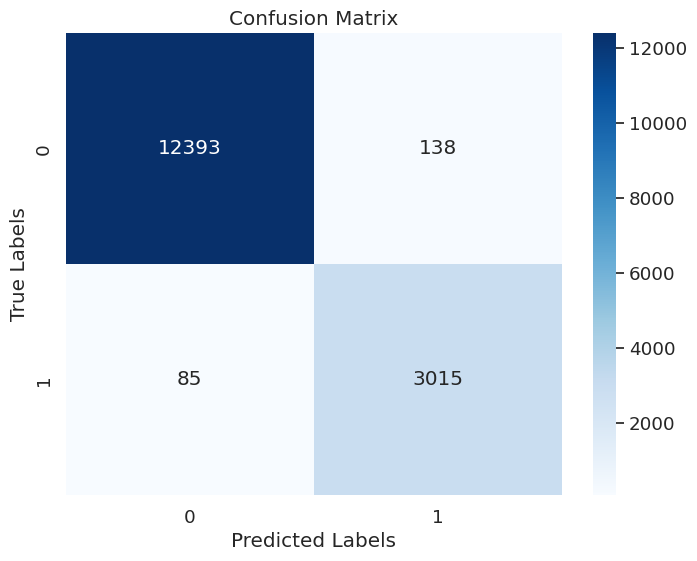

Train Precision =  0.956232159847764 
 Train Recall =  0.9725806451612903


In [58]:
analyze_model_on_train_set(seq_set_f25, RNN_LSTM)

**Model Evaluation on the Test Set**

using /kaggle/working/LSTM.h5
3/3 - 1s - loss: 0.0270 - accuracy: 0.9892 - 1s/epoch - 365ms/step
Total time taken for inferencing:  1.13  secs
Test Accurracy: 0.9892473220825195
3/3 [==============================] - 1s 4ms/step


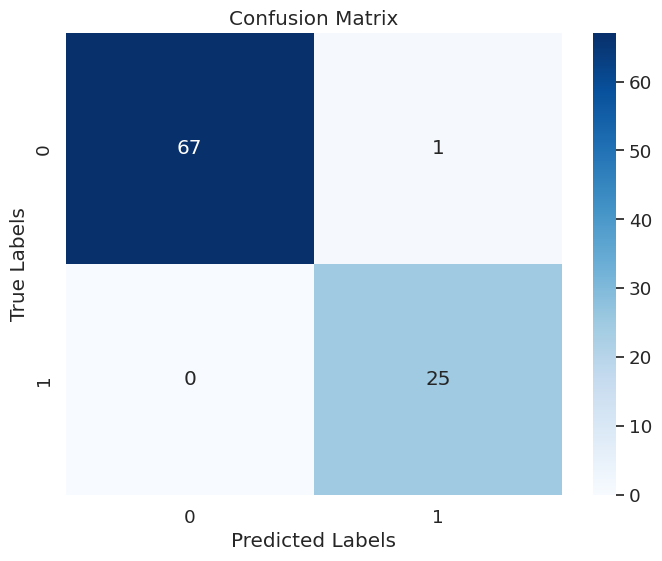

Test Precision:  0.9615384615384616 
 Test Recall:  1.0 
 Test F1-score: 0.9803921568627451


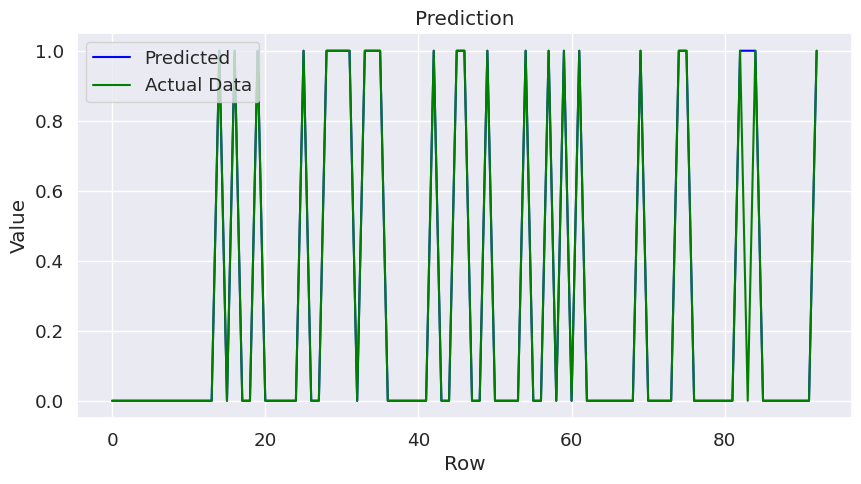

In [59]:
analyze_model_on_test_set(sequence_cols_25, RNN_LSTM_path,10,5)

# 7.5 GRU

In [60]:
# Model - (100 GRU units with 0.2 dropout) + 
#         (50 GRU units with 0.2 dropout) + 
#         (dense layer with sigmoid activation)

features_dim = seq_set_f25.shape[2] # number of features
out_dim = label_set.shape[1] # 1 Label (Target variable is failure_within_w1)

print("Features dimension: ", features_dim)
print("Output dimension: ", out_dim)

RNN_GRU = Sequential()
RNN_GRU.add(GRU(input_shape=(sequence_length, features_dim), units=100, return_sequences=True))
RNN_GRU.add(Dropout(0.2))
RNN_GRU.add(GRU(units=50, return_sequences=False))
RNN_GRU.add(Dropout(0.2))
RNN_GRU.add(Dense(units=out_dim, activation='sigmoid'))

# Compile the model
RNN_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(RNN_GRU.summary())

# Define path to save model
RNN_GRU_path = '/GRU.h5'

Features dimension:  25
Output dimension:  1
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50, 100)           38100     
                                                                 
 dropout_9 (Dropout)         (None, 50, 100)           0         
                                                                 
 gru_1 (GRU)                 (None, 50)                22800     
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 60,951
Trainable params: 60,951
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
import time
epochs = 200
batch_size = 200
start = time.time()

# Fit the network
RNN_GRU_history = RNN_GRU.fit(seq_set_f25, label_set, epochs=epochs, batch_size=batch_size, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(RNN_GRU_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )
end = time.time()
print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/200
75/75 - 4s - loss: 0.2412 - accuracy: 0.9019 - val_loss: 0.1989 - val_accuracy: 0.9258 - 4s/epoch - 60ms/step
Epoch 2/200
75/75 - 1s - loss: 0.1321 - accuracy: 0.9437 - val_loss: 0.0808 - val_accuracy: 0.9642 - 767ms/epoch - 10ms/step
Epoch 3/200
75/75 - 1s - loss: 0.0789 - accuracy: 0.9663 - val_loss: 0.0848 - val_accuracy: 0.9591 - 737ms/epoch - 10ms/step
Epoch 4/200
75/75 - 1s - loss: 0.0596 - accuracy: 0.9746 - val_loss: 0.0477 - val_accuracy: 0.9821 - 795ms/epoch - 11ms/step
Epoch 5/200
75/75 - 1s - loss: 0.0676 - accuracy: 0.9695 - val_loss: 0.0566 - val_accuracy: 0.9706 - 740ms/epoch - 10ms/step
Epoch 6/200
75/75 - 1s - loss: 0.0600 - accuracy: 0.9743 - val_loss: 0.0691 - val_accuracy: 0.9668 - 748ms/epoch - 10ms/step
Epoch 7/200
75/75 - 1s - loss: 0.0601 - accuracy: 0.9745 - val_loss: 0.0586 - val_accuracy: 0.9783 - 742ms/epoch - 10ms/step
Epoch 8/200
75/75 - 1s - loss: 0.0500 - accuracy: 0.9786 - val_loss: 0.1261 - val_accuracy: 0.9565 - 747ms/epoch - 10ms/step
Epo

**Model Evaluation on the Train and Validation Sets**

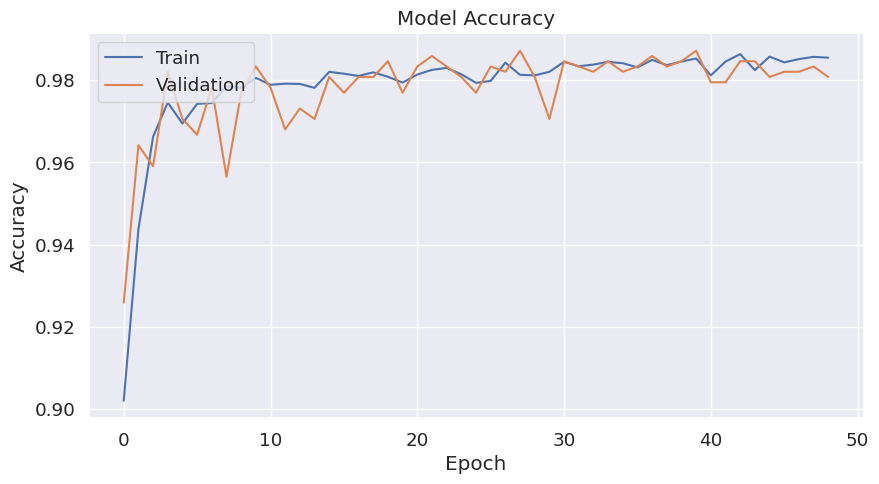

In [63]:
plot_model_accuracy(RNN_GRU_history,10,5)

**Training Curve**

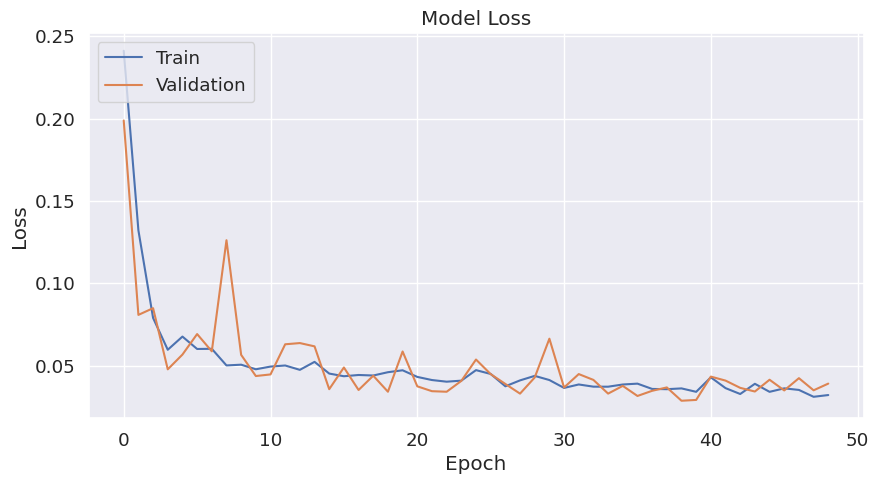

In [64]:
plot_training_curve(RNN_GRU_history,10,5)

**Model Evaluation on the Train Set**

313/313 [==============================] - 1s 4ms/step - loss: 0.0296 - accuracy: 0.9869
Train Accurracy: 0.9868850111961365
79/79 [==============================] - 1s 4ms/step


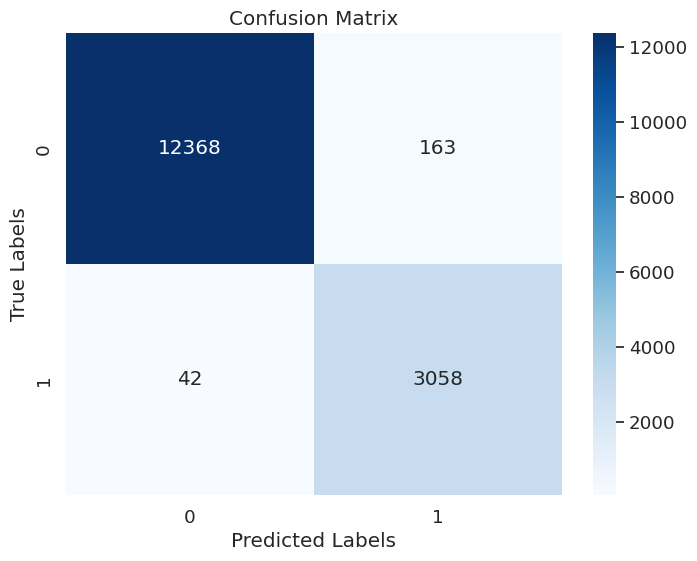

Train Precision =  0.9493945979509469 
 Train Recall =  0.9864516129032258


In [65]:
analyze_model_on_train_set(seq_set_f25, RNN_GRU)

**Model Evaluation on the Test Set**

using /kaggle/working/GRU.h5
3/3 - 1s - loss: 0.0196 - accuracy: 0.9892 - 673ms/epoch - 224ms/step
Total time taken for inferencing:  0.70  secs
Test Accurracy: 0.9892473220825195
3/3 [==============================] - 1s 4ms/step


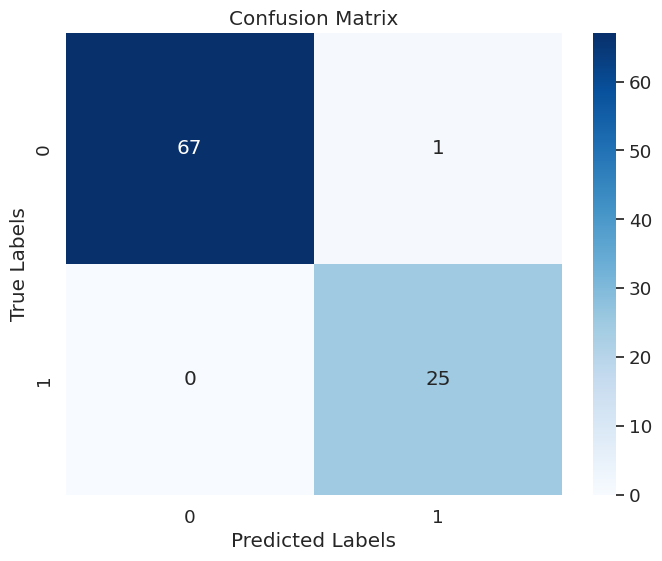

Test Precision:  0.9615384615384616 
 Test Recall:  1.0 
 Test F1-score: 0.9803921568627451


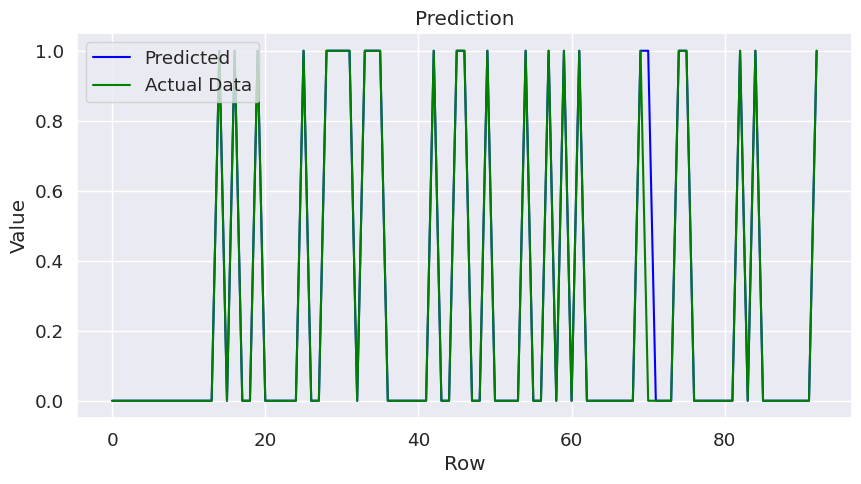

In [66]:
analyze_model_on_test_set(sequence_cols_25, RNN_GRU_path,10,5)